<a href="https://colab.research.google.com/github/keijiyo/Study_AI_recipe_book/blob/main/AI_Recipe_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 3　広告効果データ×重回帰分析モデル

## introduction

広告の費用対効果を知りたい

マーケティング・ミックス・モデリング（MMM）というフレームワークを導入

広告の出稿データと売上のような「成果データ」の因果関係をモデリングし広告効果を定量化

## レシピ3.1　要件とデータ整理

分析の前に要件とデータを整理する

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/ai_recipe/Part3CSV')
os.getcwd()

'/content/drive/MyDrive/ai_recipe/Part3CSV'

## レシピ3.2　時系列に基づいた広告データの整理

日本語化パッケージのインストール

In [ ]:
#日本語化
!pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 4.3 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=b3fe7ebaaf7f0f250805e61b9a8a5919a40dad2b8ccd44ac6f063c2a775427f9
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


ライブラリの読み込み

In [ ]:
#必要なライブラリを読込み
import pandas as pd #データフレームライブラリ
import numpy as np #配列ライブラリ
import matplotlib.pyplot as plt #グラフ描画ライブラリ
import japanize_matplotlib #グラフ日本語化ライブラリ
import seaborn as sns #高度グラフ描画ライブラリ
from scipy.optimize import curve_fit  

sns.set(font="IPAexGothic") #グラフスタイル設定
pd.options.display.max_columns = 20  #カラムの表示設定

データの紐づけ

In [ ]:
#データ読込み

#ネット広告出稿量
df_net_ad = pd.read_csv('net_ad.csv',encoding='cp932')
#TV広告出稿量
df_tv_ad = pd.read_csv('tv_ad.csv',encoding='cp932')
#気候・天候データ
df_weather = pd.read_csv('weather.csv',encoding='cp932')
#売上データ
df_sales = pd.read_csv('sales.csv',encoding='cp932')

In [ ]:
#日付で紐づけを行うために日付をインデックス化
df_net_ad = df_net_ad.set_index('ネット広告出稿日付')
df_tv_ad = df_tv_ad.set_index('TV広告出稿日付')
df_weather = df_weather.set_index('日付')
df_sales = df_sales.set_index('売上日付')

In [ ]:
#ファイルを日付で結合する カラム名「金額」をそれぞれ対応する名前に直す
df = pd.concat(
    [df_net_ad.rename(columns={'金額':'ネット広告出稿金額'}),
     df_tv_ad.rename(columns={'金額':'TV出稿金額'}).drop('曜日',axis=1),#曜日は重複するため落とす
     df_weather,
     df_sales.rename(columns={'金額':'売上金額'}).drop('曜日',axis=1) #曜日は重複するため落とす
     ]
    ,axis=1
)
#インデックスをdatetime型に変換
df.index = pd.to_datetime(df.index)

結果の出力

In [ ]:
print (df)

           曜日  ネット広告出稿金額    TV出稿金額  平均気温    降水量     天気     売上金額
2020-04-06  月     100000  500000.0  12.1    0.0      晴  1500000
2020-04-07  火      60000       NaN  12.4    0.0     薄曇  1300000
2020-04-08  水      70000       NaN  14.3    0.0     快晴  1350000
2020-04-09  木      60000       NaN  13.3    0.5    晴後曇  1300000
2020-04-10  金      50000       NaN  11.2    0.0  晴一時薄曇  1250000
2020-04-11  土      60000       NaN  11.4    0.5  晴後時々曇  1300000
2020-04-12  日      70000       NaN  10.3    6.5   曇一時雨  1350000
2020-04-13  月      60000  300000.0   8.0  132.0     大雨  1300000
2020-04-14  火      40000       NaN  10.9    1.5     快晴  1200000
2020-04-15  水      60000       NaN  13.8    0.0  薄曇一時晴  1300000
2020-04-16  木      70000       NaN  11.7    0.5      曇  1350000
2020-04-17  金      60000       NaN  12.4    0.5   曇時々晴  1300000
2020-04-18  土      20000       NaN  12.9   89.5     大雨  1100000
2020-04-19  日      20000       NaN  14.7    0.0      晴  1100000


## レシピ3.3　相関分析と説明変数の作成

データの読み込み

In [ ]:
#モデリング用サンプルデータ読込
df = pd.read_csv('sample_data.csv',encoding='cp932').set_index('日付')
#インデックスをdatetime型に変換
df.index = pd.to_datetime(df.index)
print (df)

           曜日  ネット広告出稿金額  TV広告出稿金額  平均気温   降水量               天気         売上金額
日付                                                                          
2019-04-01  月        0.0       0.0   8.8   5.5              晴後曇  151579.5187
2019-04-02  火        0.0       NaN   7.2   0.0              晴後曇  162928.9412
2019-04-03  水        0.0       NaN   8.1   0.0               快晴  161903.2741
2019-04-04  木        0.0       NaN  10.6   0.0               快晴  333822.8260
2019-04-05  金        0.0       NaN  15.4   0.0             薄曇後晴  249339.9429
...        ..        ...       ...   ...   ...              ...          ...
2020-03-27  金        0.0       NaN  16.2   0.0                曇  358478.2009
2020-03-28  土        0.0       NaN  15.5   8.5             曇時々雨  188774.2805
2020-03-29  日        0.0       NaN   3.6  51.5  雨時々雪後一時曇、みぞれを伴う  109710.9521
2020-03-30  月        0.0       0.0   7.6   0.0                曇  104810.5188
2020-03-31  火        0.0       NaN   9.8   0.0             曇時々雨  218285.3157

広告費と売上金額の関係（時系列）

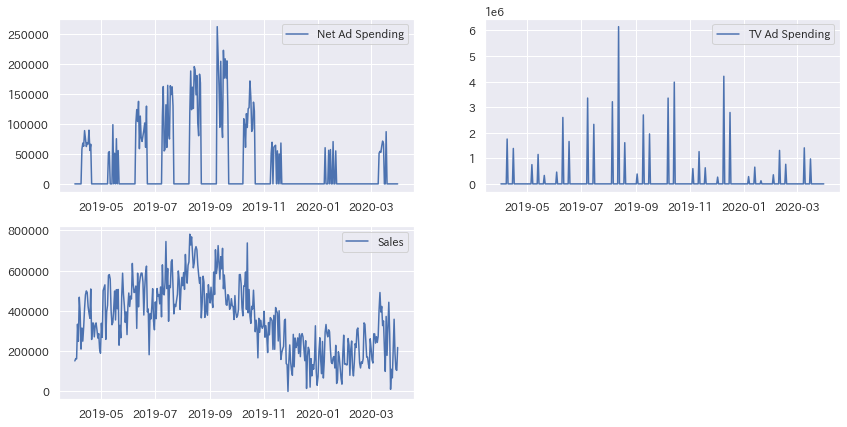

In [ ]:
#広告費と売上金額時系列可視化
plt.figure(figsize=(14,7))
plt.subplot(2,2,1)
plt.plot(df['ネット広告出稿金額'],label='Net Ad Spending')
plt.legend()
plt.subplot(2,2,2)
plt.plot(df['TV広告出稿金額'].fillna(0),label='TV Ad Spending')
plt.legend()
plt.subplot(2,2,3)
plt.plot(df['売上金額'],label='Sales')
plt.legend()

データの削除

In [ ]:
#天気データを落とす
df = df.drop(['天気'],axis=1)

月曜起点の週次データに変換

In [ ]:
#月曜起点の週次データに変換
temp = df['TV広告出稿金額'].resample('W-MON').sum() 
print (temp)

日付
2019-04-01    0.000000e+00
2019-04-08    1.753920e+06
2019-04-15    1.385894e+06
2019-04-22    0.000000e+00
2019-04-29    0.000000e+00
2019-05-06    7.532542e+05
2019-05-13    1.151631e+06
2019-05-20    3.300517e+05
2019-05-27    0.000000e+00
2019-06-03    4.614095e+05
2019-06-10    2.597596e+06
2019-06-17    1.658120e+06
2019-06-24    0.000000e+00
2019-07-01    0.000000e+00
2019-07-08    3.356151e+06
2019-07-15    2.328423e+06
2019-07-22    0.000000e+00
2019-07-29    0.000000e+00
2019-08-05    3.212541e+06
2019-08-12    6.148227e+06
2019-08-19    1.610823e+06
2019-08-26    0.000000e+00
2019-09-02    3.868730e+05
2019-09-09    2.697258e+06
2019-09-16    1.954091e+06
2019-09-23    0.000000e+00
2019-09-30    0.000000e+00
2019-10-07    3.354881e+06
2019-10-14    3.978068e+06
2019-10-21    0.000000e+00
2019-10-28    0.000000e+00
2019-11-04    5.968054e+05
2019-11-11    1.262201e+06
2019-11-18    6.301300e+05
2019-11-25    0.000000e+00
2019-12-02    2.647992e+05
2019-12-09    4.207878e+0

TV広告出稿金額を7（1週間の日数）で割り、前行のNaNに対し穴埋めしていく。

In [ ]:
#7で割る
temp /=7
#最後に日時にする
temp=temp.asfreq('1D',method='ffill')
#元のデータフレームに格納する
df['TV広告出稿金額'] = temp
print (df)

           曜日  ネット広告出稿金額  TV広告出稿金額  平均気温   降水量         売上金額
日付                                                         
2019-04-01  月        0.0       0.0   8.8   5.5  151579.5187
2019-04-02  火        0.0       0.0   7.2   0.0  162928.9412
2019-04-03  水        0.0       0.0   8.1   0.0  161903.2741
2019-04-04  木        0.0       0.0  10.6   0.0  333822.8260
2019-04-05  金        0.0       0.0  15.4   0.0  249339.9429
...        ..        ...       ...   ...   ...          ...
2020-03-27  金        0.0       0.0  16.2   0.0  358478.2009
2020-03-28  土        0.0       0.0  15.5   8.5  188774.2805
2020-03-29  日        0.0       0.0   3.6  51.5  109710.9521
2020-03-30  月        0.0       0.0   7.6   0.0  104810.5188
2020-03-31  火        0.0       0.0   9.8   0.0  218285.3157

[366 rows x 6 columns]


日次変換後のTV広告出稿金額の確認

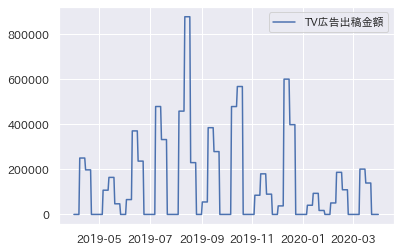

In [ ]:
#日次変換後のTV広告出稿金額
plt.plot(df['TV広告出稿金額'],label='TV広告出稿金額')
plt.legend()

各変数と売上変数の関係確認

回帰直線の周りにある薄い青色の幅は、95%信頼区間。  

平均気温とは正の相関、降水量とは負の相関なので、暑いときに売れる物のデータっぽい。

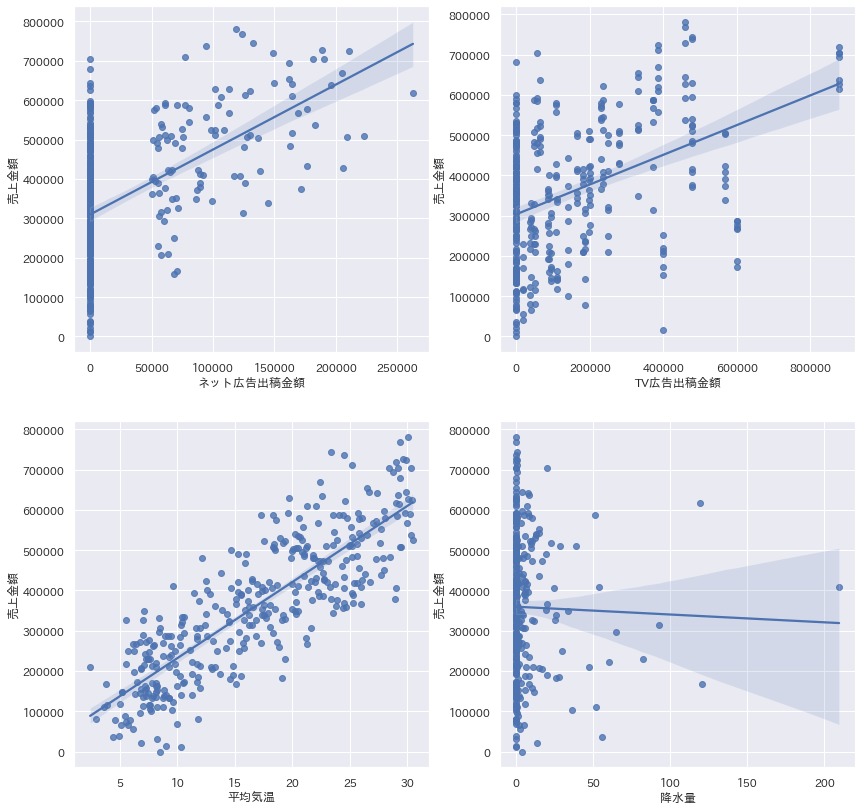

In [ ]:
#各変数と売上変数の散布図
plt.figure(figsize=(14,14))
plt.subplot(2,2,1)
sns.regplot(x="ネット広告出稿金額", y="売上金額", data=df)

plt.subplot(2,2,2)
sns.regplot(x="TV広告出稿金額", y="売上金額", data=df)

plt.subplot(2,2,3)
sns.regplot(x="平均気温", y="売上金額", data=df)

plt.subplot(2,2,4)
sns.regplot(x='降水量', y="売上金額", data=df)

曜日と売上の関係確認

週末に売上が高い（ビールのデータ？）

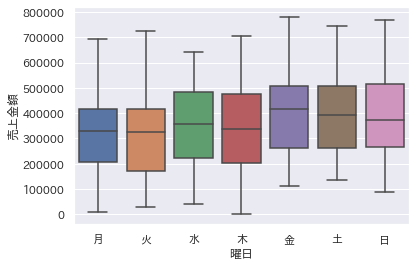

In [ ]:
#曜日ごとに売上の傾向に違いがあるか
sns.boxplot(x='曜日', y="売上金額", data=df)

変数の整理

In [ ]:
#曜日→週末FLGに変換
df['週末FLG'] = (df['曜日'].isin(['金','土','日'])).astype('int')
#不要な変数(曜日と天気)落とす 曜日は上で週末FLGを作成したため以降不要
df = df.drop(['曜日'],axis=1)

データの確認

In [ ]:
#確認
print (df)

            ネット広告出稿金額  TV広告出稿金額  平均気温   降水量         売上金額  週末FLG
日付                                                             
2019-04-01        0.0       0.0   8.8   5.5  151579.5187      0
2019-04-02        0.0       0.0   7.2   0.0  162928.9412      0
2019-04-03        0.0       0.0   8.1   0.0  161903.2741      0
2019-04-04        0.0       0.0  10.6   0.0  333822.8260      0
2019-04-05        0.0       0.0  15.4   0.0  249339.9429      1
...               ...       ...   ...   ...          ...    ...
2020-03-27        0.0       0.0  16.2   0.0  358478.2009      1
2020-03-28        0.0       0.0  15.5   8.5  188774.2805      1
2020-03-29        0.0       0.0   3.6  51.5  109710.9521      1
2020-03-30        0.0       0.0   7.6   0.0  104810.5188      0
2020-03-31        0.0       0.0   9.8   0.0  218285.3157      0

[366 rows x 6 columns]


Abstock効果の確認

Abstock効果：「広告効果（特にTV広告）は、広告にユーザーが接触した日だけでなく、その翌日以降も効果が減衰しながら継続する」という考え方とのこと。
  
日付をシフトさせる

In [ ]:
#TV広告出稿金額4日前まで取得する
df_tv_shift = pd.concat(
    [df['売上金額'],
     df[['TV広告出稿金額']].rename(columns={'TV広告出稿金額':'TV広告出稿金額_1'}).shift(1).fillna(0), #1日前の出稿金額
     df[['TV広告出稿金額']].rename(columns={'TV広告出稿金額':'TV広告出稿金額_2'}).shift(2).fillna(0), #2日前の出稿金額
     df[['TV広告出稿金額']].rename(columns={'TV広告出稿金額':'TV広告出稿金額_3'}).shift(3).fillna(0), #3日前の出稿金額
     df[['TV広告出稿金額']].rename(columns={'TV広告出稿金額':'TV広告出稿金額_4'}).shift(4).fillna(0)  #4日前の出稿金額
     ],axis=1)

In [ ]:
# shift(n).fillna(n)のチェック
df_tv_shift[0:14]

,売上金額,TV広告出稿金額_1,TV広告出稿金額_2,TV広告出稿金額_3,TV広告出稿金額_4
日付,,,,,
2019-04-01,151579.5187,0.000000,0.000000,0.000000,0.000000
2019-04-02,162928.9412,0.000000,0.000000,0.000000,0.000000
2019-04-03,161903.2741,0.000000,0.000000,0.000000,0.000000
2019-04-04,333822.8260,0.000000,0.000000,0.000000,0.000000
2019-04-05,249339.9429,0.000000,0.000000,0.000000,0.000000
2019-04-06,467929.9996,0.000000,0.000000,0.000000,0.000000
2019-04-07,391287.8366,0.000000,0.000000,0.000000,0.000000
2019-04-08,210324.7675,0.000000,0.000000,0.000000,0.000000
2019-04-09,314850.1030,250559.997286,0.000000,0.000000,0.000000


TV広告出稿金額と売上金額の関係

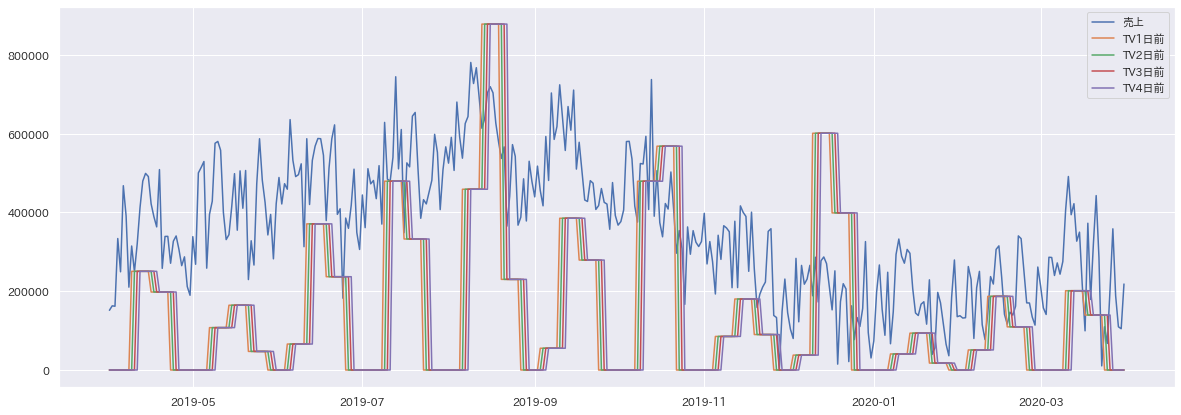

In [ ]:
#時系列plot
plt.figure(figsize=(20,7))
plt.plot(df_tv_shift['売上金額'],label='売上')
plt.plot(df_tv_shift['TV広告出稿金額_1'],label='TV1日前')
plt.plot(df_tv_shift['TV広告出稿金額_2'],label='TV2日前')
plt.plot(df_tv_shift['TV広告出稿金額_3'],label='TV3日前')
plt.plot(df_tv_shift['TV広告出稿金額_4'],label='TV4日前')
plt.legend()

In [ ]:
#TVの1-4日前の出稿金額変数をマージする
df = pd.concat(
    [df,
     df_tv_shift.drop(['売上金額'],axis=1)]
     ,axis=1
)

散布図で確認

日が経つにつれ相関は弱くなっていくものの正の相関はある。

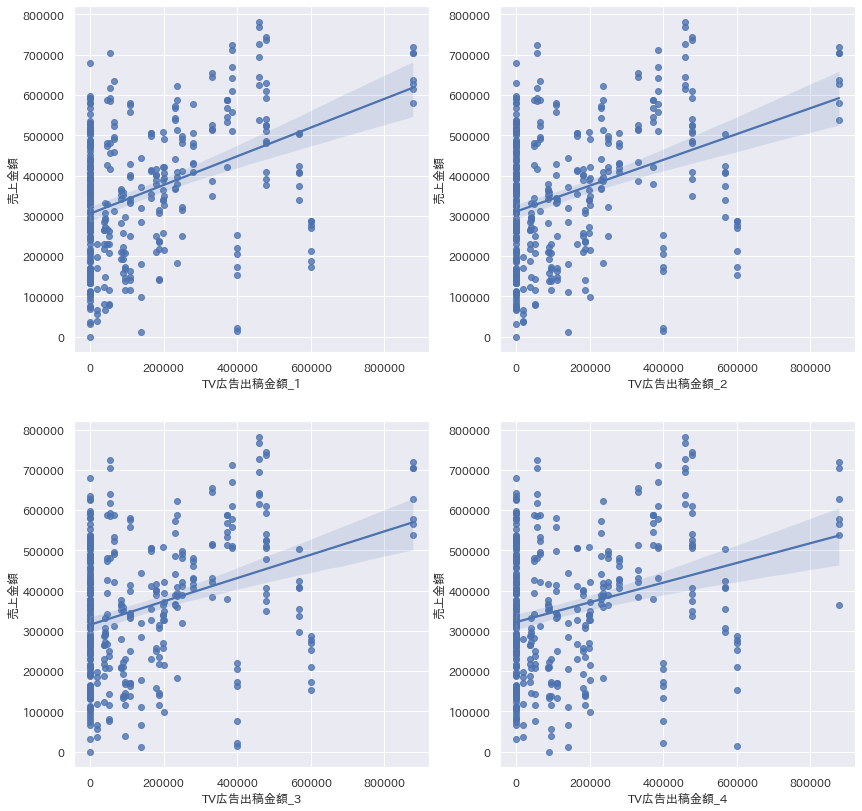

In [ ]:
#同じように散布図
plt.figure(figsize=(14,14))
plt.subplot(2,2,1)
sns.regplot(x="TV広告出稿金額_1", y="売上金額", data=df_tv_shift)

plt.subplot(2,2,2)
sns.regplot(x="TV広告出稿金額_2", y="売上金額", data=df_tv_shift)

plt.subplot(2,2,3)
sns.regplot(x="TV広告出稿金額_3", y="売上金額", data=df_tv_shift)

plt.subplot(2,2,4)
sns.regplot(x='TV広告出稿金額_4', y="売上金額", data=df_tv_shift)


## レシピ3.4　モデルの構築


対数での近似

※curve_fit()：最小二乗法で曲線近似する最適パラメータを求めることができる（非線形最小二乗法）

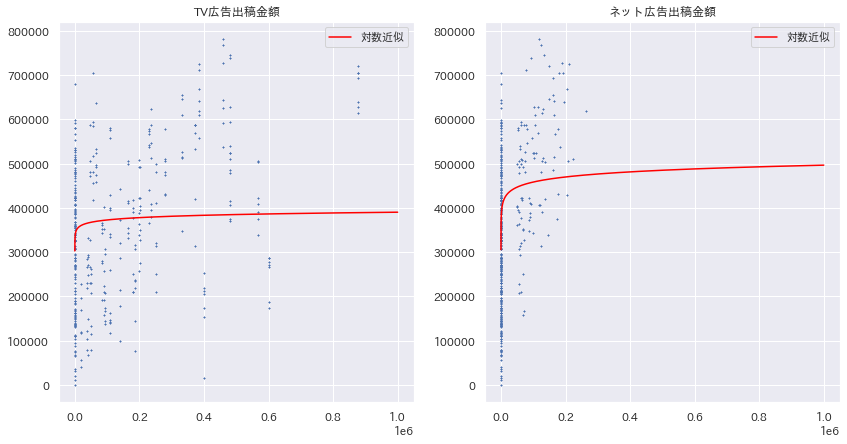

In [ ]:
#対数近似
#対数近似関数定義
def func1(X, a, b): 
    return a*np.log(X+1) + b

plt.figure(figsize=(14,7))
#TV
popt, pcov = curve_fit(func1,df['TV広告出稿金額'],df['売上金額']) # poptは最適推定値、pcovは共分散
plt.subplot(1,2,1)
plt.plot(popt[0]*np.log(np.linspace(0,100000,1000000)+1)+popt[1],label='対数近似',color='red')
plt.scatter(df['TV広告出稿金額'],df['売上金額'],marker='x',s=1)
plt.title('TV広告出稿金額')
plt.legend()

#ネット
popt, pcov = curve_fit(func1,df['ネット広告出稿金額'],df['売上金額']) # poptは最適推定値、pcovは共分散
plt.subplot(1,2,2)
plt.plot(popt[0]*np.log(np.linspace(0,100000,1000000)+1)+popt[1],label='対数近似',color='red')
plt.scatter(df['ネット広告出稿金額'],df['売上金額'],marker='x',s=1)
plt.title('ネット広告出稿金額')
plt.legend()

In [ ]:
# poptの確認
popt

array([ 16563.48221989, 305587.05638666])

注）
「import pystan」が「ModuleNotFoundError: No module named 'pystan'」となった。  
「import stan」で動作するようだが、バージョンを下げることでサンプルコードのまま動作した。

In [ ]:
!pip list | grep 'pystan'

pystan                        3.3.0


In [ ]:
!pip install pystan==2.19.1.1 # バージョンを下げて再インストール

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 89 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0


pystanライブラリの読み込み

In [ ]:
#MCMCのライブラリ読み込む
import pystan

#対象データを作成する
X = df[['ネット広告出稿金額','TV広告出稿金額','TV広告出稿金額_1','TV広告出稿金額_2','平均気温','降水量','週末FLG']]
y = df['売上金額']

メモ：  
モデル式  

$$ y_i = \beta_0 + \beta_1 \times \log ({ネット}_t + 1) + \beta_2 \times (\log ({TV}_t +1) + λ \log({TV}_{t-1} + 1) + λ^2 \log({TV}_{t-2} + 1)) \\ + \beta_3 \times ({平均気温}_t) + \beta_4 \times ({降水量}_t) + \beta_5 \times ({週末FLG}_t) + e $$

- TVの出稿金額は2日前(${TV}_{t-2}$)までを使用する。
-Adstock効果についてモデル式への組み込み：  
 $λ$：減衰パラメータ（$0 < λ < 1$）をTV広告に適用。
- 広告の逓減効果についてモデル式への組み込み：  
一般的に投下量が大きくなるにつれて、その効果は減少する。  
これを対数化でモデルに組み込む。→ネット広告、TV広告に適用。

**（重回帰モデルでなくMCMCを使うのは、$\beta_2$が複数の項にかかるため）**

モデルの定義

In [ ]:
#pystanの準備

model = """
data {
  int<lower=0> N;
  vector[N] Net;
  vector[N] TV;
  vector[N] TV_1;
  vector[N] TV_2;
  vector[N] temp;
  vector[N] rain;
  vector[N] weekend;
  vector[N] y;
}
parameters { 
  real beta_0;
  real beta_1;
  real beta_2;
  real beta_3;
  real beta_4;
  real beta_5;
  real<lower=0, upper=1> lambda;
  real<lower=0> sigma;
}

model { 
  for (i in 1:N)
      y[i] ~ normal(beta_0 + beta_1*log(Net[i]+1)+ beta_2 * (log(TV[i]+1)+lambda*log(TV_1[i]+1)+lambda^(2)*log(TV_2[i]+1))+beta_3*temp[i]+beta_4*rain[i]+beta_5*weekend[i], sigma);
}
"""

入力データの作成

In [ ]:
#pystanに食わせるデータ定義（辞書型）
dat = {'N':len(X), 'Net': X['ネット広告出稿金額'].values,'TV': X['TV広告出稿金額'].values,
       'TV_1': X['TV広告出稿金額_1'].values,'TV_2': X['TV広告出稿金額_2'].values,'temp': X['平均気温'].values, 'rain': X['降水量'].values,'weekend': X['週末FLG'].values,'y': y.values}

MCMCの実行

In [ ]:
#MCMC実行
fit = pystan.stan(model_code=model, data=dat, seed=12345)

可視化のためarvizライブラリのインストール

In [ ]:
#MCMC結果を可視化するライブラリインストール
!pip install arviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


サンプリング結果の確認

※デフォルトでは4つの連鎖系列を作る

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f28f89586d0>,
      dtype=object)

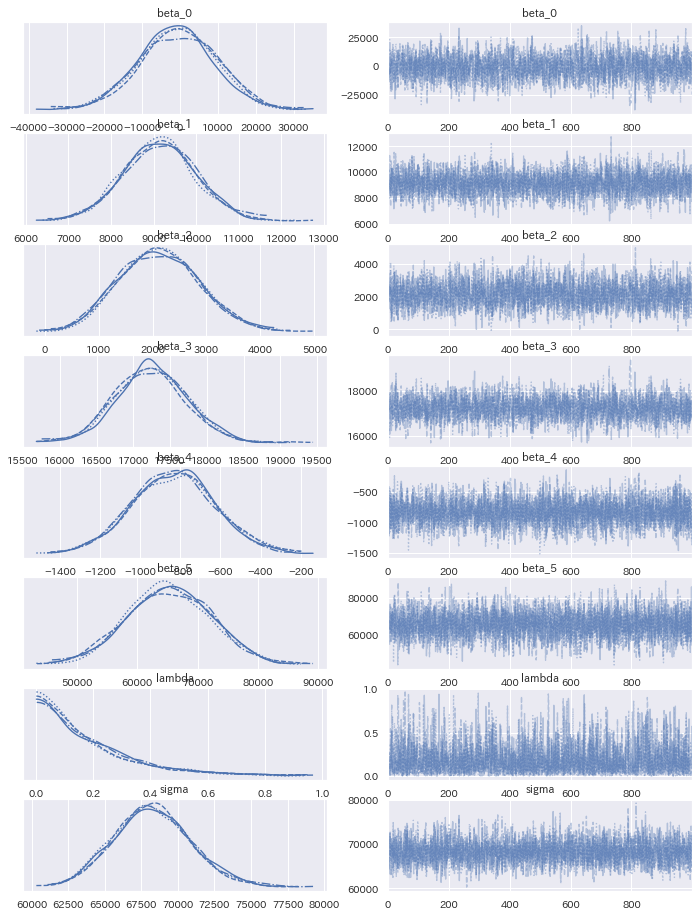

In [ ]:
#結果可視化
import arviz
arviz.plot_trace(fit)

In [ ]:
print (fit)

Inference for Stan model: anon_model_d18a784032dc3ccca2c2b1150fbbba4a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_0 -683.2  230.94  1.0e4 -2.1e4  -7391 -652.5 6215.3  1.8e4   1918    1.0
beta_1 9144.3   15.24 848.17 7462.2 8575.5 9146.6 9696.3  1.1e4   3096    1.0
beta_2 2131.9   14.69 735.43 755.99 1617.6 2114.1 2626.2 3617.0   2508    1.0
beta_3  1.7e4   10.18 485.07  1.6e4  1.7e4  1.7e4  1.8e4  1.8e4   2272    1.0
beta_4 -830.5    3.28  206.4  -1242 -971.6 -829.0 -695.1 -415.6   3953    1.0
beta_5  6.5e4  110.68 6944.9  5.2e4  6.1e4  6.5e4  7.0e4  7.9e4   3938    1.0
lambda   0.18  3.1e-3   0.17 4.8e-3   0.06   0.13   0.26   0.65   2964    1.0
sigma   6.8e4   38.23 2598.4  6.3e4  6.6e4  6.8e4  7.0e4  7.4e4   4620    1.0
lp__    -4247    0.05   2.06  -4252  -4248  -4247  -4245  -4244   1481    1.0

Samples were drawn using NUTS 

In [ ]:
#2019年度総広告出稿金額
df[['ネット広告出稿金額','TV広告出稿金額']].sum(axis=0).sum()

65600939.930690005

In [ ]:
df[['ネット広告出稿金額','TV広告出稿金額']].sum(axis=0)

ネット広告出稿金額    1.084632e+07
TV広告出稿金額     5.475462e+07
dtype: float64

## レシピ3.5　結果に基づいた最適な広告戦略の立案

書籍では、広告出稿量の最適化を行うという事で、目的関数と制約条件を設定し連立方程式（連立不等式）を解くExcelのソルバー機能の使用例あり。